# Deconvolution of Three AML Patient Cohorts

We conducted deconvolution of cell subtype proportions utilizing bulk RNA-seq samples from three distinct AML cohorts: beatAML, Leucegene, and TCGA-AML. Our approach involved using only cells from Van Galen et al. dataset under pre-treatment conditions, and genes exhibiting positive biological variance. Employing the CLIMB method, we subsequently show a comprehensive landscape of cell subtype proportions within the context of AML.

In [ ]:
# Load general Libraries
library(Matrix) ; library(ggplot2) ; library(RColorBrewer) ; library(dplyr) 
library(IRdisplay) ; library(reshape2) ; library(ggpubr)
library(xbioc) ; library(ComplexHeatmap) ;  library(ggpmisc)
library(SingleCellExperiment) ; library(circlize) ; library(MASS)
# Deconvolution methods 
library(MuSiC) ; library(BayesPrism); library(BisqueRNA)
library(ClimbTheCliff) ; library(glmnet)

### Important functions

In [8]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){ return( sign(cor(pr,tr)) * cor(pr,tr)^2 ) }
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    # per row metrics:
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    # per-column metrics:
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    # overall metrics:
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 
### Function for each deconvolution methods ### 
deconvolution_climb <- function(sc, bulks, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = F, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_climb_dw <- function(sc, bulks, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = T, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_bayesprism <- function(sc, bulks, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="state")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
deconvolution_music <- function(sc, bulks, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    music_prop = music.output$Est.prop.weighted
    music_prop = add_missing_celltypes(music_prop, celltype_names)
    return(music_prop[,celltype_names])
}
deconvolution_nnls <- function(sc, bulks, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    nnls_prop = music.output$Est.prop.allgene
    nnls_prop = add_missing_celltypes(nnls_prop, celltype_names)
    return(nnls_prop[,celltype_names])
}
deconvolution_bisque <- function(sc, bulks, celltype_names){
    bisque.out = BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap=F)
    bisque_prop = t(bisque.out$bulk.props)
    bisque_prop = add_missing_celltypes(bisque_prop, celltype_names)
    return(bisque_prop[,celltype_names])
}
deconvolution_random <- function(nnls_prop){
    nnls_prop = read.csv(paste0(out_dir, '/nnls_prop.csv'), row.names='X')
    set.seed(1)
    rand_prop = nnls_prop[sample(rownames(nnls_prop)), sample(colnames(nnls_prop))]
    rownames(rand_prop) = rownames(nnls_prop) ; colnames(rand_prop) = colnames(nnls_prop)
    return(rand_prop)
}
write_tables_cibersortx <- function(sc, bulks, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # Reformulate to add 'Gene' at the start of the file
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_pbulks.txt > ', 
    #              tab_dir, '/cibersortx_pbulks.txt'))
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_sc_mat.txt > ', 
    #              tab_dir, '/cibersortx_sc_mat.txt'))
    # remove temp files
    #system(paste0('rm ',tab_dir, '/TMP_*'))
}
write_tables_tape_scaden <- function(sc, bulks, celltype_names, tab_dir){
    # Write all input tables formatted for TAPE / Scaden
    write.csv(t(exprs(bulks)), paste0(tab_dir, "/tape_scaden_bulks_expr.csv"), quote=F)
    sc_mat_TAPE = exprs(sc)
    sc_mat_TAPE = t(sc_mat_TAPE)
    rownames(sc_mat_TAPE) = sc$cellType
    write.csv(sc_mat_TAPE, paste0(tab_dir, "/tape_scaden_scmat_expr.csv"), quote=F)
}
deconvolution_scaden <- function(sc, bulks, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden / TAPE deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_TAPE_and_Scaden.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  '../REVISION_1/data/celltype_expression/TAPE/input/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')
    climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='X')
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB-DW', 'CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB-DW', 'CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    return(all_p)
}                                                                                           

launch_deconvolution_cohort <- function(sc, bulks, celltype_names, out_dir){ 
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    write.csv(celltype_names, paste0(out_dir, '/celltype_names.csv'), quote=F)

    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    
    ### CLIMB deconvolution ###
    message('CLIMB-DW deconvolution')
    climb_dw_prop = deconvolution_climb_dw(sc, bulks, celltype_names)
    write.csv(climb_dw_prop, paste0(out_dir, '/climb_dw_prop.csv'), quote=F)
    
    ### BayesPrism deconvolution ###
    message('BayesPrism deconvolution')
    bayesprism_prop = deconvolution_bayesprism(sc, bulks, celltype_names)
    write.csv(bayesprism_prop, paste0(out_dir, '/bayesprism_prop.csv'), quote=F)
    
    ### MUSIC deconvolution ###
    message('MUSIC deconvolution')
    music_ps = deconvolution_music(sc, bulks, celltype_names)
    write.csv(music_ps, paste0(out_dir, '/music_prop.csv'), quote=F)
    
    ### NNLS deconvolution ### 
    message('NNLS deconvolution')
    nnls_prop = deconvolution_nnls(sc, bulks, celltype_names)
    write.csv(nnls_prop, paste0(out_dir, '/nnls_prop.csv'), quote=F)
    
    ### BisqueRNA deconvolution ### 
    message('BisqueRNA deconvolution')
    bisque_prop = deconvolution_bisque(sc, bulks, celltype_names)
    write.csv(bisque_prop, paste0(out_dir, '/bisque_prop.csv'), quote=F)

    ### Deconvolution Scaden / TAPE 
    message('TAPE / Scaden deconvolution')
    write_tables_tape_scaden(sc, bulks, celltype_names, tmp_dir)
    deconvolution_scaden(sc, bulks, celltype_names, tmp_dir)
    tape_prop = load_tape_prop(tmp_dir, out_dir, celltype_names)
    scaden_prop = load_scaden_prop(tmp_dir, out_dir, celltype_names)

    ### Random proportions deconvolution ### 
    message('Random deconvolution')
    rand_prop = deconvolution_random(nnls_prop)
    write.csv(rand_prop, paste0(out_dir, '/rand_prop.csv'), quote=F)
    
    ### CiberSortX deconvolution ### 
    message('Writing tables for CiberSortX')
    write_tables_cibersortx(sc, bulks, celltype_names, tmp_dir)
}   
compute_vangalen_signature <- function(file_signature, b.es){
    ct_signatures = read.csv(file_signature)
    celltypes = c('HSC-like', 'Prog-like', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')
    colnames(ct_signatures) <- celltypes
    bulk_cpm = t(1e6*(t(exprs(b.es)) / colSums(exprs(b.es))))
    bulk_cpm_scale = t(scale(t(bulk_cpm)))
    signature_scores_l = list() ; signature_scores_l.bma = list()
    for(k in 1:length(celltypes)){
        celltype = colnames(ct_signatures)[k]
        sel.sign = rownames(bulk_cpm_scale) %in% ct_signatures[,k]
        sign = colMeans(bulk_cpm_scale[sel.sign,])
        signature_scores_l[[k]] = num(sign)
    }
    return(signature_scores_l)
}

## Load useful tables

In [9]:
vangalen_sign_file = 'data/aml_3cohorts/cancer_cell_type_signature.csv'

In [39]:
# Load merged metadata from 3 cohorts
metadata = read.csv('data/aml_3cohorts/merge_metadata.csv', row.names='X')

In [50]:
# Extract all bulk sample IDs that are from Bone Marrow Aspirate origin
bma.samples = rownames(metadata)[metadata$tissue_type == 'Bone Marrow Aspirate']

## Load reference scRNA-seq data

We use Van Galen et al. reference dataset with its original cell subtype labels. It contains cells under pre-treatment conditions (only samples from day 0). Genes were filtered to have positive biological variance based on variance between cells in the Van Galen dataset. We use Van Galen as a reference single-cell RNA-seq as it was not purified was FACS and should contain more even cell subtype proportions compared to Naldini's dataset.

In [10]:
sc.es = readRDS("data/pseudobulks_climb/AML_vangalen_sc_es.RDS")
sc.es$cellType = factor(reformat_celltypes(sc.es$cellType))
celltype_names = reformat_celltypes(levels(sc.es$cellType))

# Launch CLIMB deconvolution on 3 AML cohorts

In the next few cells we will launch CLIMB deconvolution on the cohorts of AML patients. There is a total of 628 bone marrow samples, which take approximately 12 hours to run. Alternatively, the processed deconvoluted data can be loaded afterwards for analysis.

## Launch CLIMB Deconvolution panel on BeatAML cohort

In [73]:
# define beatAML output directory
beataml.out_dir = 'data/aml_3cohorts/beat_aml_deconvolution'

# Load BeatAML bulk samples
bulk.es = readRDS("data/aml_3cohorts/beatAML_bulk_es_451s.RDS")

# Extract bone marrow samples
bulk.es.bma = bulk.es[,colnames(bulk.es) %in% bma.samples]

In [61]:
# Run CLIMB, WARNING: takes around 6 hours
climb_out.beataml = climb(sc = sc.es, bulk = bulk.es.bma, mode='abundance')

ABUNDANCE mode: predicting cell-type proportions in bulks

6606 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 



climb_prop.beataml = climb_out.beataml$props
rownames(climb_prop.beataml) = colnames(bulk.es.bma)

## Launch CLIMB Deconvolution on TCGA cohort

In [75]:
# define TCGA-AML analysis output directory
tcga.out_dir = 'data/aml_3cohorts/tcga_aml_deconvolution'

# Load TCGA-AML bulk samples
bulk.es = readRDS('data/aml_3cohorts/TCGA_AML_bulk_es.RDS')

# Extract bone marrow samples
bulk.es.bma = bulk.es[,colnames(bulk.es) %in% bma.samples]

In [63]:
# Run CLIMB, WARNING: takes around 3/4 hours
climb_out.tcga = climb(sc = sc.es, bulk = bulk.es.bma, mode='abundance')

ABUNDANCE mode: predicting cell-type proportions in bulks

6606 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 



In [76]:
climb_prop.tcga = climb_out.tcga$props
rownames(climb_prop.tcga) = colnames(bulk.es.bma)

## Launch CLIMB deconvolution on Leucegene cohort

In [77]:
# define Leucegene analysis output directory
leucegene.out_dir = 'data/aml_3cohorts/leucegene_aml_deconvolution/'

# Load Leucegene bulk sample to deconvolute
bulk.es = readRDS("data/aml_3cohorts/leucegene_bulk_all_es.RDS")

# Extract bone marrow samples
bulk.es.bma = bulk.es[,colnames(bulk.es) %in% bma.samples]

In [65]:
# Launch CLIMB only
climb_out.leucegene = climb(sc = sc.es, bulk = bulk.es.bma, mode='abundance')

ABUNDANCE mode: predicting cell-type proportions in bulks

6543 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 



In [78]:
climb_prop.leucegene = climb_out.leucegene$props
rownames(climb_prop.leucegene) = colnames(bulk.es)
# leucegene sample names needs to be reformated
rownames(climb_prop.leucegene) = gsub('X','',rownames(climb_prop.leucegene))

## Assemble results from three datasets

In [95]:
climb_prop.3datasets = rbind(climb_prop.tcga, climb_prop.leucegene, climb_prop.beataml)

In [104]:
# check sample name order
all(rownames(climb_prop.3datasets) == rownames(metadata))

[1] TRUE

In [113]:
write.csv(climb_prop.3datasets, 'data/aml_3cohorts/climb_prop_3datasets.csv', quote=F)

## Draw heatmap with all props from 3 datasets

In [125]:
# load pre-processed results:
climb_prop.3datasets = read.csv('data/aml_3cohorts/climb_prop_3datasets.csv', row.names = 'X')

In [126]:
metadata$sample_name = rownames(metadata)
FAB_onehot = dcast(data = metadata, sample_name ~ FAB, length)
FAB_onehot = FAB_onehot[match(rownames(metadata), FAB_onehot$sample_name),]

Using sample_name as value column: use value.var to override.



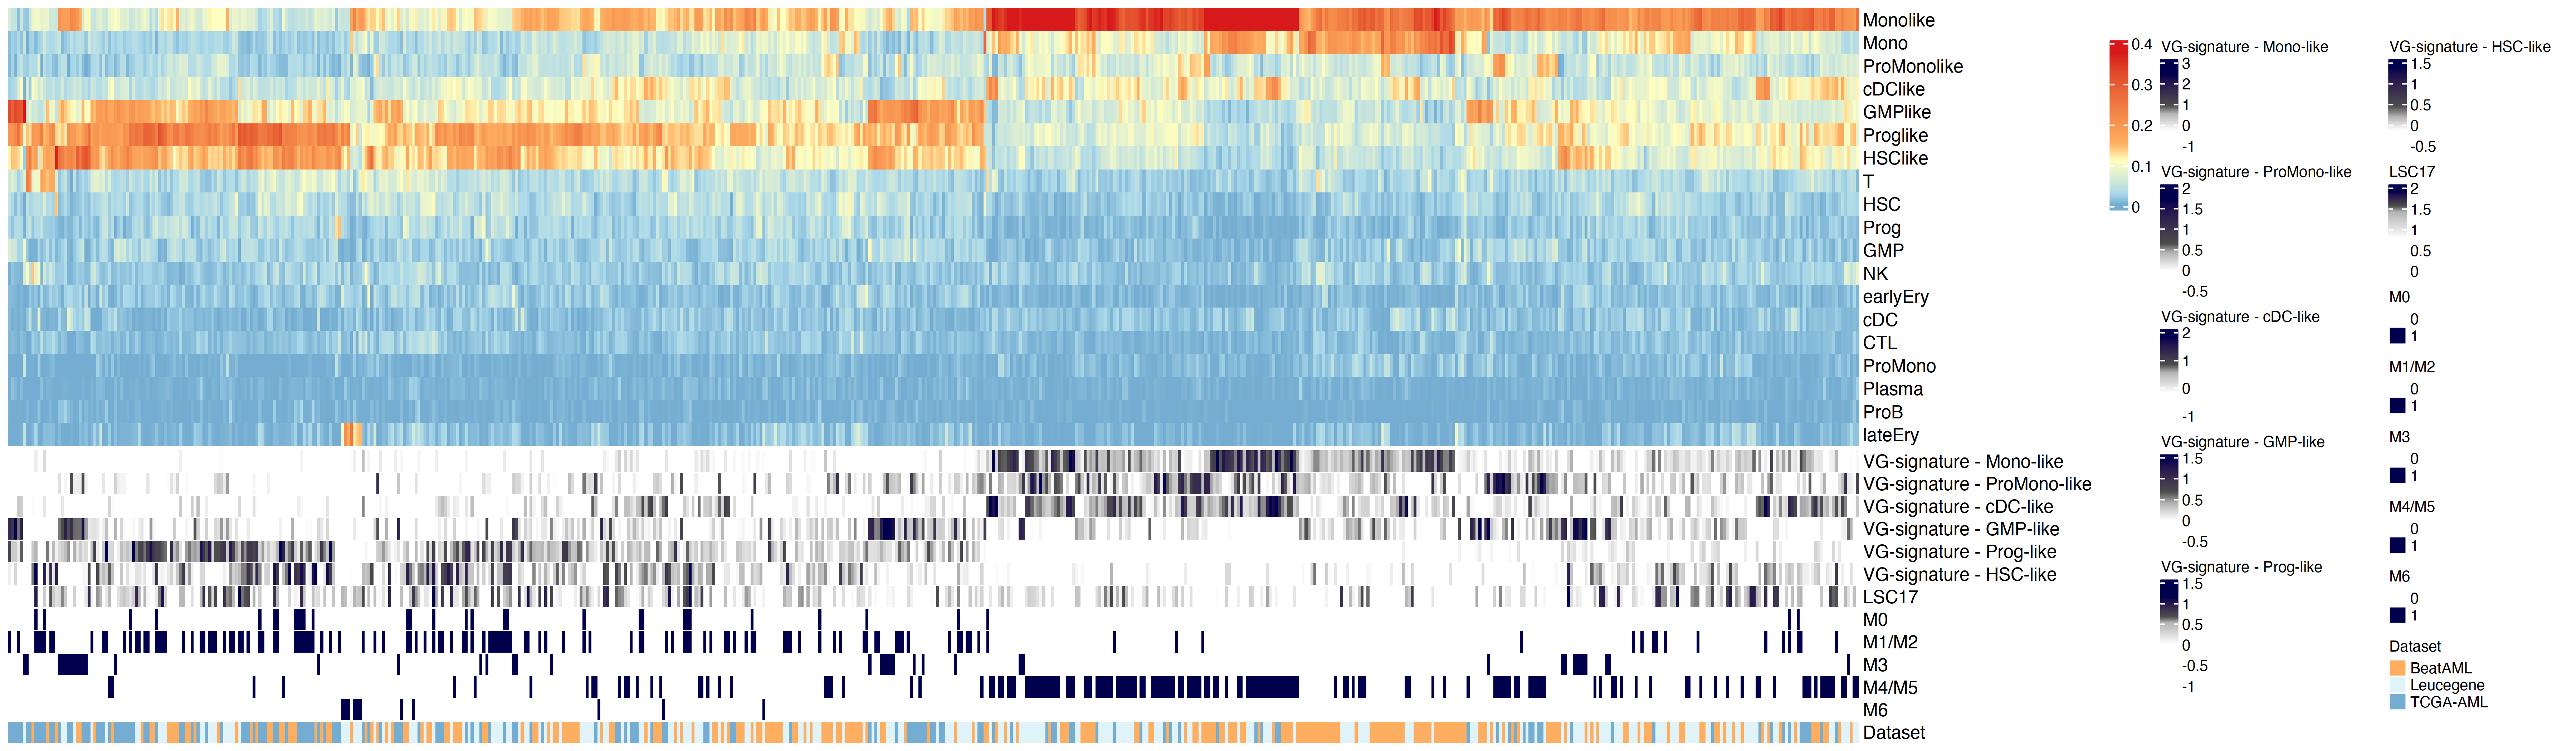

In [127]:
options(repr.plot.width = 24, repr.plot.height = 7, repr.plot.res = 300)
col_panel_vg = c("white", "white", "grey70","grey30", "#00004d")
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
p_signature = c(0.05,0.5,0.85,0.92,0.995)
col_fun = colorRamp2(num(quantile(num(as.vector(as.matrix(climb_prop.3datasets)))[num(as.vector(as.matrix(climb_prop.3datasets))) !=0], 
                                  p=p_signature)), col_panel)
col_fun_hsclike = colorRamp2(num(quantile(metadata$VG_HSClike, p=p_signature)), col_panel_vg)
col_fun_proglike = colorRamp2(num(quantile(metadata$VG_Proglike, p=p_signature)), col_panel_vg)
col_fun_gmplike = colorRamp2(num(quantile(metadata$VG_GMPlike, p=p_signature)), col_panel_vg)
col_fun_promonolike = colorRamp2(num(quantile(metadata$VG_ProMonolike, p=p_signature)), col_panel_vg)
col_fun_monolike = colorRamp2(num(quantile(metadata$VG_Monolike, p=p_signature)), col_panel_vg)
col_fun_cdclike = colorRamp2(num(quantile(metadata$VG_cDClike, p=p_signature)), col_panel_vg)
col_fun_lsc17 = colorRamp2(num(quantile(metadata$LSC17, p=p_signature)), col_panel_vg)
col_fun_FAB = c('0' = 'white', '1' = '#00004d')
column_ha = HeatmapAnnotation(`VG-signature - Mono-like` = metadata$VG_Monolike,
                              `VG-signature - ProMono-like` = metadata$VG_ProMonolike,
                              `VG-signature - cDC-like` = metadata$VG_cDClike,
                              `VG-signature - GMP-like` = metadata$VG_GMPlike,
                              `VG-signature - Prog-like` = metadata$VG_Proglike,
                              `VG-signature - HSC-like` = metadata$VG_HSClike,
                              `LSC17` = metadata$LSC17, 
                              `M0` = FAB_onehot$M0, `M1/M2` = ifelse(FAB_onehot$M0+FAB_onehot$M1>0, 1,0),
                              `M3` = FAB_onehot$M3, `M4/M5` = ifelse(FAB_onehot$M4+FAB_onehot$M5>0, 1,0),
                              `M6` = FAB_onehot$M6,
                              `Dataset` = metadata$dataset,
                              col = list(`VG-signature - GMP-like` = col_fun_gmplike, `VG-signature - HSC-like`=col_fun_hsclike,
                                         `VG-signature - Mono-like` = col_fun_monolike, `VG-signature - ProMono-like`=col_fun_promonolike,
                                         `VG-signature - Prog-like`=col_fun_proglike, `VG-signature - cDC-like`=col_fun_cdclike,
                                          `LSC17` = col_fun_lsc17, `Dataset` = c("BeatAML" = '#fdae61', "Leucegene" =  '#e0f3f8', "TCGA-AML" = '#74add1'),
                                         `M0` = col_fun_FAB, `M1/M2` = col_fun_FAB, `M3` = col_fun_FAB, 
                                         `M4/M5` = col_fun_FAB, `M6` = col_fun_FAB))
input_mat= t(climb_prop.3datasets)[c('Monolike', 'Mono', 'ProMonolike','cDClike', 'GMPlike', 'Proglike', 'HSClike',
                     'T', 'HSC', 'Prog', 'GMP', 'NK', 'earlyEry', 'cDC', 'CTL', 'ProMono', 'Plasma', 'ProB', 'lateEry'),]
h = Heatmap(input_mat, show_column_names=F, show_row_dend = F, show_column_dend = F, 
        bottom_annotation = column_ha, col = col_fun, cluster_rows=F,
        #row_split = names_split,
        cluster_row_slices = FALSE, row_title_rot = 0,
        heatmap_legend_param = list(title = "",legend_height = unit(4, "cm")))
#pdf('results/fig3/Heatmap_CLIMB_3datasets_withScores_final.pdf', width=22, height=7) ; h ; dev.off()
h

## Draw additional plots to compare with FAB / LSC17 / Van Galen signatures

Hereafter we make a correlation between cancer cell subtypes and LSC17 signature, which show a higher correlation for undifferentiated cancer cell subtypes (HSC-like, Prog-like), and an anti-correlation for differentiated cell subtypes (Monocyte-like, ProMonocyte-like subtypes).

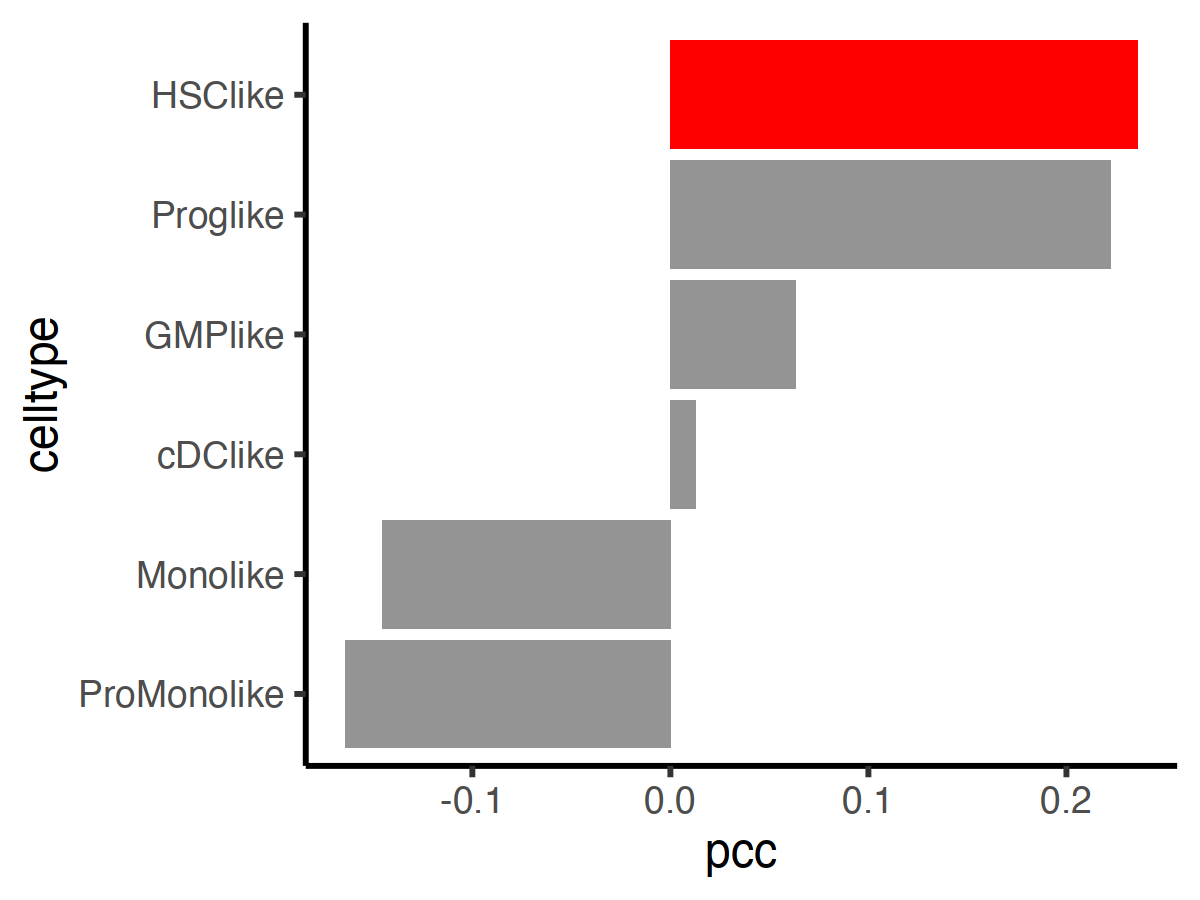

In [139]:
# We correlates cancer cell subtypes with LSC17 signatures
cor_lsc17 = cor(climb_prop.3datasets, metadata$LSC17)
cor_lsc17 = cor_lsc17[grepl('like',rownames(cor_lsc17)),]

cor_lsc17 = data.frame(celltype=names(cor_lsc17), pcc=num(cor_lsc17))
cor_lsc17$celltype = factor(cor_lsc17$celltype, levels=cor_lsc17$celltype[order(num(cor_lsc17$pcc))])
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)
ggplot(cor_lsc17) + geom_col(aes(y=celltype, x=pcc, fill=celltype),show.legend = FALSE) + 
    scale_fill_manual(values=ifelse(grepl('HSClike', as.character(levels(cor_lsc17$celltype))), 'red', 'grey58')) + theme_classic()

Here we now make a correlation between deconvoluted cell subtype proportions and scores obtained from van galen signature genes of the corresponding cell subtypes.

In [136]:
cor_mat_vg = cor(climb_prop.3datasets[,c('Monolike','ProMonolike', 'cDClike', 'GMPlike', 'Proglike', 'HSClike')], 
                 metadata[,c('VG_Monolike', 'VG_ProMonolike', 'VG_cDClike', 'VG_GMPlike', 'VG_Proglike', 'VG_HSClike')])

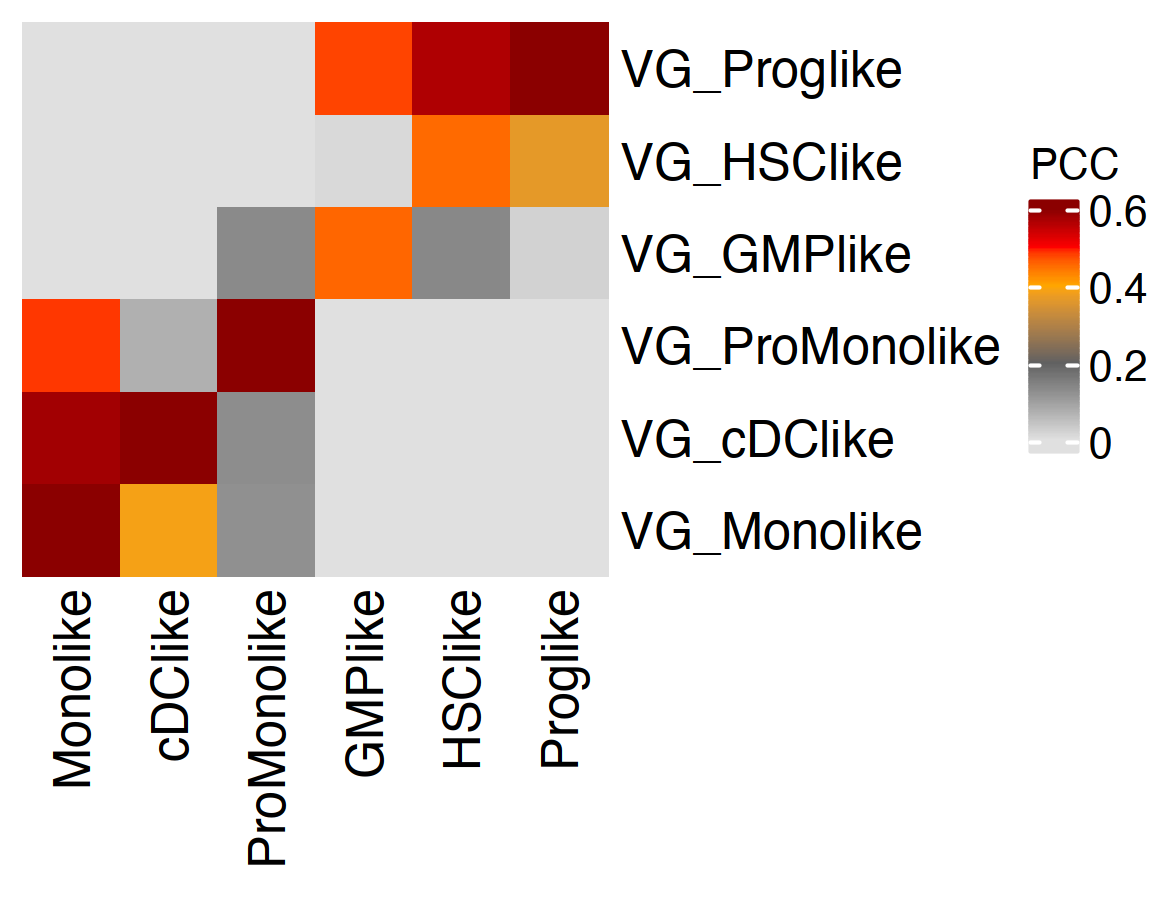

In [138]:
col_fun = colorRamp2(c(0,0.2,0.4,0.5,0.6), rev(c("darkred", "red", "orange", "grey38", "grey88")))
options(repr.plot.width = 3.9, repr.plot.height = 3, repr.plot.res = 300)
Heatmap(t(cor_mat_vg), col=col_fun, show_row_dend=F, show_column_dend=F, name='PCC')

We observe a good concordence translated as a high correlation on the diagonal of the heatmap.